In [2]:
pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.6.7-py3-none-any.whl size=11961 sha256=236c22d7712b2cf596df14d141085d574bb004b5034d0e2f3a72810087abcf83
  Stored in directory: c:\users\julie\appdata\local\pip\cache\wheels\dd\dc\1c\c472efa84814edbb5b67d132ad3950534d0d7fd808543a659c
Successfully built empiricaldist
Note: you may need to restart the kernel to use updated packages.


In [3]:
# • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ Pyfunctions ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ • ~ •
# Librerías y/o depedencias
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from scipy import stats
#from yellowbrick.classifier import ClassBalance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import empiricaldist
sns.set_theme(context='notebook', style=plt.style.use('dark_background'))

# Carga de datos

In [4]:
df= pd.read_csv('cobranza.csv')

In [5]:
# Downcasting
# Función para reducir el peso en memoria de un DataFrame
def downcast_dtypes(data:pd.DataFrame) -> pd.DataFrame:

    """
    Function to downcast any type variable

    Args:
        dataframe: DataFrame
    
    Return:
        DataFrame: Downcasted DataFrame
    """

    start = data.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [col for col in data if data[col].dtype == 'float64']
    int_cols = [col for col in data if data[col].dtype in ['int64', 'int32']]
    object_cols = [col for col in data if data[col].dtype in ['object', 'bool']]

    data[float_cols] = data[float_cols].astype(np.float32)
    data[int_cols] = data[int_cols].astype(np.int16)
    data[object_cols] = data[object_cols].astype('category')

    end = data.memory_usage(deep=True).sum() / 1024 ** 2
    saved = (start - end) / start * 100
    print(f'Memory Saved: {saved:0.2f}%', '\n')

    return data.info()

In [6]:
downcast_dtypes(data=df)

Memory Saved: 96.18% 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87485 entries, 0 to 87484
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   producto                    87485 non-null  category
 1   valor vencido               87485 non-null  float32 
 2   regional                    87485 non-null  int16   
 3   franja                      87485 non-null  category
 4   segmento                    87476 non-null  category
 5   cuadrante                   87485 non-null  category
 6   descripcion causal          87485 non-null  category
 7   calificacion real           87485 non-null  int16   
 8   fecha de perfeccionamiento  87485 non-null  category
 9   rango endeudamiento         87485 non-null  category
 10  ocupacion                   87485 non-null  category
dtypes: category(8), float32(1), int16(2)
memory usage: 1.6 MB


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87485 entries, 0 to 87484
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   producto                    87485 non-null  category
 1   valor vencido               87485 non-null  float32 
 2   regional                    87485 non-null  int16   
 3   franja                      87485 non-null  category
 4   segmento                    87476 non-null  category
 5   cuadrante                   87485 non-null  category
 6   descripcion causal          87485 non-null  category
 7   calificacion real           87485 non-null  int16   
 8   fecha de perfeccionamiento  87485 non-null  category
 9   rango endeudamiento         87485 non-null  category
 10  ocupacion                   87485 non-null  category
dtypes: category(8), float32(1), int16(2)
memory usage: 1.6 MB


In [8]:
# Capturar variables
# Función para capturar los tipos de variables
def capture_variables(data:pd.DataFrame) -> tuple:
    
    """
    Function to capture the types of Dataframe variables

    Args:
        dataframe: DataFrame
    
    Return:
        variables: A tuple of lists
    
    The order to unpack variables:
    1. numericals
    2. continous
    3. categoricals
    4. discretes
    5. temporaries
    """

    numericals = list(data.select_dtypes(include = [np.int16, np.float32]).columns)
    categoricals = list(data.select_dtypes(include = ['category', 'bool']).columns)
    temporaries = list(data.select_dtypes(include = ['datetime', 'timedelta']).columns)
    discretes = [col for col in data[numericals] if len(data[numericals][col].unique()) < 20]
    continuous = [col for col in data[numericals] if col not in discretes]

    # Variables
    print('\t\tTipos de variables')
    print(f'Hay {len(continuous)} variables continuas')
    print(f'Hay {len(discretes)} variables discretas')
    print(f'Hay {len(temporaries)} variables temporales')
    print(f'Hay {len(categoricals)} variables categóricas')
    
    variables = tuple((numericals, continuous, categoricals, discretes, temporaries))

    # Retornamos una tupla de listas
    return variables

In [9]:
numericals, continous, categorical, discretes, temporaries=  capture_variables(data=df)

		Tipos de variables
Hay 2 variables continuas
Hay 1 variables discretas
Hay 0 variables temporales
Hay 8 variables categóricas


In [10]:
# Resumen estadistico de variables cuantitativas
df[numericals].describe().T

,count,mean,std,min,25%,50%,75%,max
valor vencido,87485.0,709768.750000,1.888078e+06,20010.0,104099.0,242456.0,613878.5,183108688.0
regional,87485.0,3595.539327,2.324808e+03,0.0,2099.0,2099.0,5499.0,8799.0
calificacion real,87485.0,1.722238,9.228404e-01,0.0,1.0,2.0,2.0,3.0


In [11]:
df[categorical].describe().T

,count,unique,top,freq
producto,87485,6,tarjetas de credito,51132
franja,87485,6,<30,61875
segmento,87476,4,personal plus,47408
cuadrante,87485,6,tiene voluntad y tiene capacidad reducida,33086
descripcion causal,87485,53,descuido,24546
fecha de perfeccionamiento,87485,4360,2015-06-12,380
rango endeudamiento,87485,6,1-15,44648
ocupacion,87485,11,sin oficio,55499


In [12]:
df['fecha de perfeccionamiento'].value_counts()

2015-06-12    380
2014-08-04    188
2014-11-24    177
2014-12-23    175
2014-12-09    166
             ... 
2001-09-20      1
2001-09-19      1
2001-09-14      1
2001-09-13      1
1970-10-01      1
Name: fecha de perfeccionamiento, Length: 4360, dtype: int64

In [13]:
# Asimetría entre predictores
# Función para obtener la asimetría de los predictores
def get_skew(data:pd.DataFrame) -> any:

    """
    Function to get skew by classes

    Args:
        data: DataFrame
    
    Return:
        print
    """

    tmp = data.skew().sort_values(ascending=False)
    tmp = dict(tmp)
    
    print('\t\tAsimetría entre predictores')
    for key, value in tmp.items():
        print(f'{key}: {value:0.2f}')

In [14]:
get_skew(data=df[numericals])

		Asimetría entre predictores
valor vencido: 22.44
regional: 0.71
calificacion real: -0.13


In [15]:
# Diagnóstico de variables
# Función para observar el comportamiento de variables continuas
def diagnostic_plots(data:pd.DataFrame, variables:list) -> any:

    """
    Function to get diagnostic graphics into 
    numerical (continous and discretes) predictors

    Args:
        data: DataFrame
        variables: list
    
    Return:
        Dataviz
    """
        
    for var in data[variables]:
        
        fig, axes = plt.subplots(1, 4, figsize=(16, 5))
        fig.suptitle('Diagnostic Plots', fontsize=16)
        plt.rcParams.update({'figure.max_open_warning': 0}) # Evitar un warning

        # Histogram Plot
        plt.subplot(1, 4, 1)
        plt.title('Histogram Plot')
        # empiricaldist.Pmf.from_seq(data[var], normalize=False, dropna=False).bar(color='midnightblue', edgecolor='white', lw=0.3)
        sns.histplot(data[var], bins=25, color='midnightblue', edgecolor='white', lw=0.3)
        plt.axvline(data[var].mean(), color='#E51A4C', ls='dashed', lw=1.5, label='Mean')
        plt.axvline(data[var].median(), color='gold', ls='dashed', lw=1.5, label='Median')
        plt.ylabel('Cantidad')
        plt.xticks(rotation=25)
        plt.xlabel(var)
        plt.grid(True)
        plt.legend()
        
        # CDF Plot
        plt.subplot(1, 4, 2)
        plt.title('CDF Plot')
        xs = np.linspace(data[var].min(), data[var].max())
        ys = stats.norm(data[var].mean(), data[var].std()).cdf(xs) # Distribución normal a partir de unos datos
        plt.plot(xs, ys, color='cornflowerblue', ls='dashed')
        empiricaldist.Cdf.from_seq(data[var], normalize=True).plot(color='chartreuse')
        plt.xlabel(var)
        plt.xticks(rotation=25)
        plt.ylabel('Probabilidad')
        plt.legend(['Distribución normal', var], fontsize=7.5, loc='upper left')
        plt.grid(True)

        # PDF Plot
        plt.subplot(1, 4, 3)
        plt.title('PDF Plot')
        xs = np.linspace(data[var].min(), data[var].max())
        ys = stats.norm(data[var].mean(), data[var].std()).pdf(xs) # Distribución normal a partir de unos datos
        plt.plot(xs, ys, color='cornflowerblue', ls='dashed')
        sns.kdeplot(data=data, x=data[var], fill=True, lw=0.5, color='crimson', alpha=0.4, edgecolor='white')
        plt.ylabel('Densidad')
        plt.xticks(rotation=25)
        plt.xlabel(var)
        plt.legend(['Distribución normal', var], fontsize=7.5, loc='upper right')
        plt.grid(True)

        # Boxplot & Stripplot
        plt.subplot(1, 4, 4)
        plt.title('Boxplot')
        sns.boxplot(data=data[var], width=0.5, color='orangered', linewidth=2.25)
        sns.stripplot(data=data[var], color='aliceblue', alpha=1, size=2.25)
        plt.xlabel(var)
        plt.tick_params(labelbottom=False)
        plt.ylabel('Unidad')
        plt.grid(True)        
        
        fig.tight_layout()

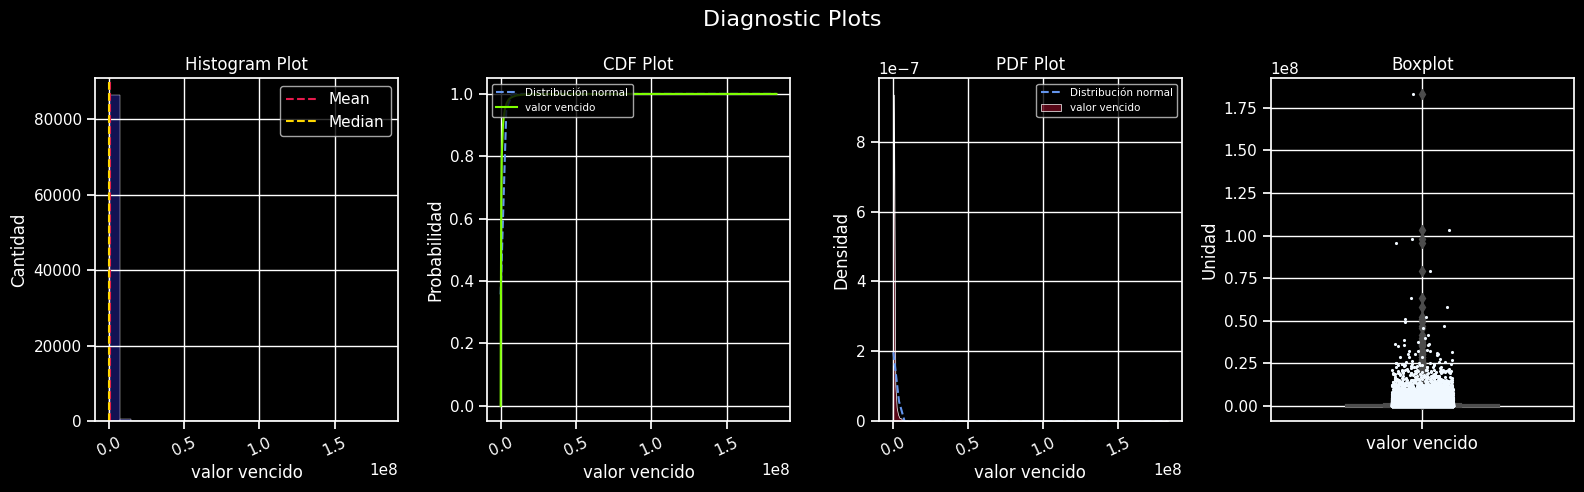

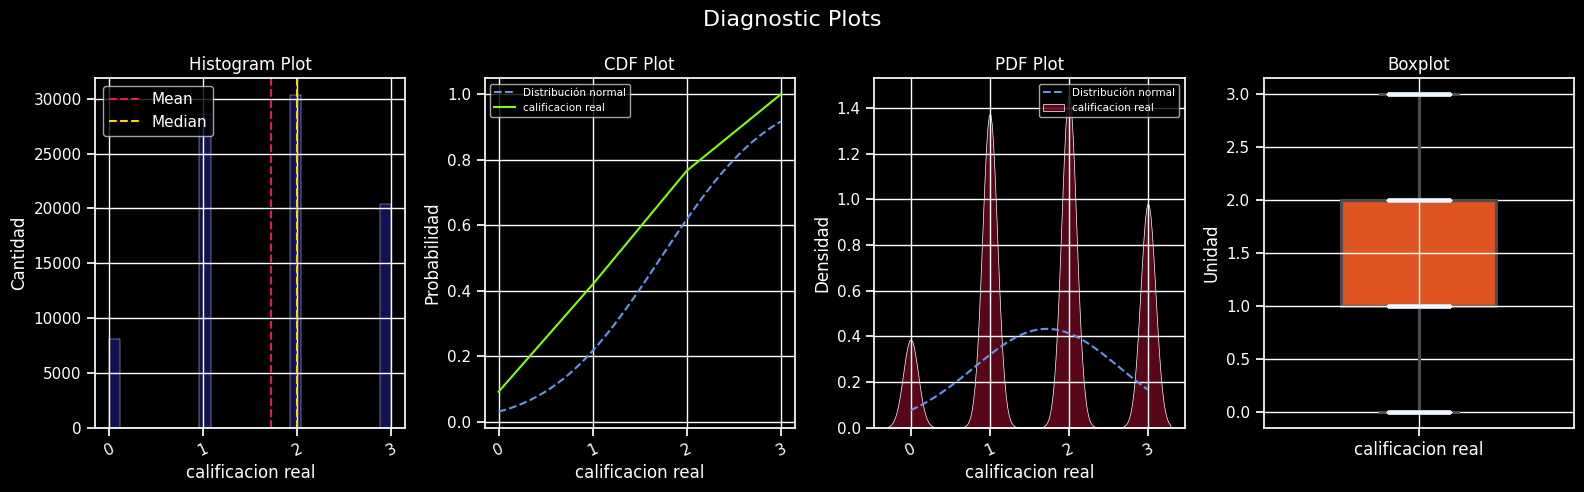

In [82]:
diagnostic_plots(data=df,variables=numericals)

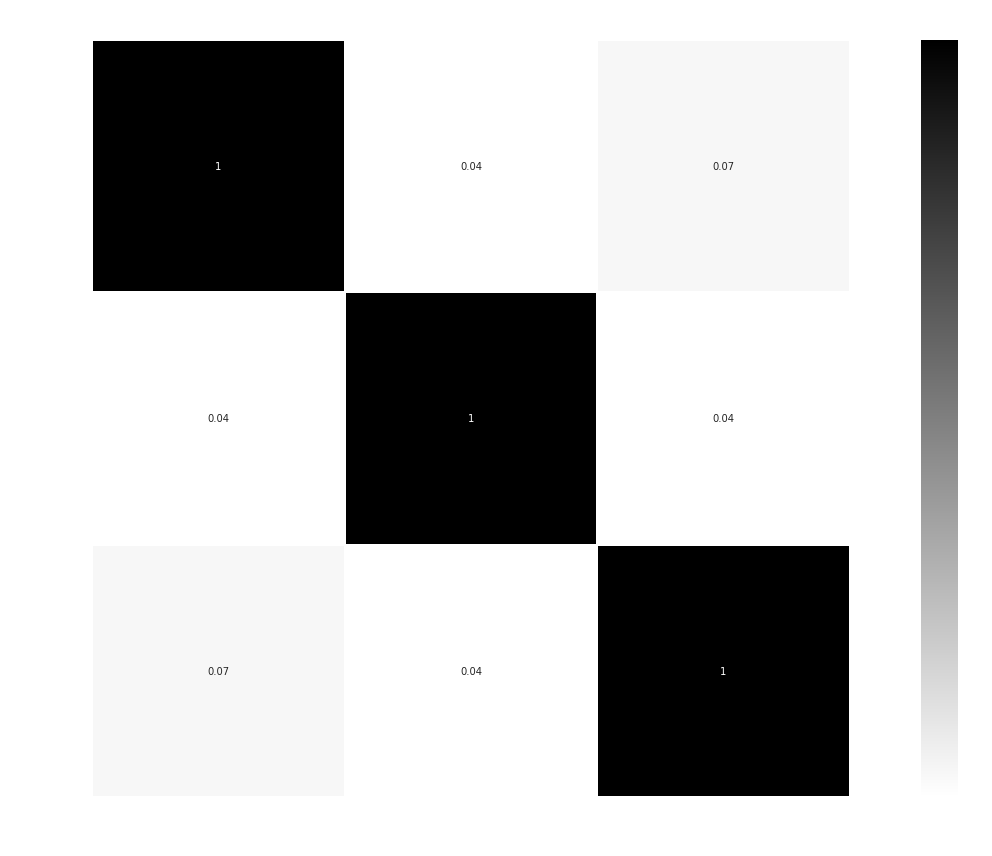

In [17]:
# Correlacion entre variables
%matplotlib  inline 
correlation = df[numericals].corr(method='pearson').round(2)
plt.figure(figsize=(20,12))
sns.heatmap(correlation, vmax=1, annot=True, cmap='gist_yarg',linewidths=1,square=True)
plt.title('Matriz de correlacion\n', fontsize=14)
plt.xticks(fontsize=10, rotation=25)
plt.yticks(fontsize=10, rotation=25)
plt.tight_layout()

In [18]:
# Revisar la cardinalidad de variables categóricas y discretas
# Función para graficar variables categóricas
def categoricals_plot(data:pd.DataFrame, variables:list) -> any:

    """
    Function to get distributions graphics into 
    categoricals predictors

    Args:
        data: DataFrame
        variables: list
    
    Return:
        Dataviz
    """
    
    plt.suptitle('Categoricals plot', fontsize=16)
    for var in variables:
        temp_dataframe = pd.Series(data[var].value_counts() / len(data))

        # Graficar con los porcentajes
        temp_dataframe.sort_values(ascending=False).plot.bar(color='lavender', edgecolor='skyblue')

        # Añadir una línea horizontal a 5% para resaltar categorías poco comunes
        plt.axhline(y=0.05, color='#E51A4C', ls='dashed', lw=1.5)
        plt.ylabel('Porcentajes')
        plt.xlabel(var)
        plt.xticks(rotation=25)
        plt.grid(True)
        plt.show()

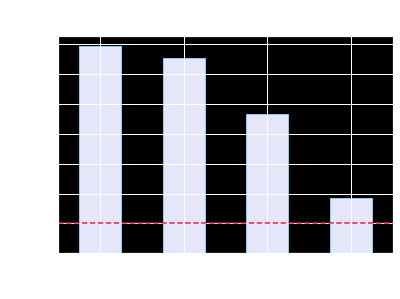

In [19]:
categoricals_plot(data=df,variables=discretes)

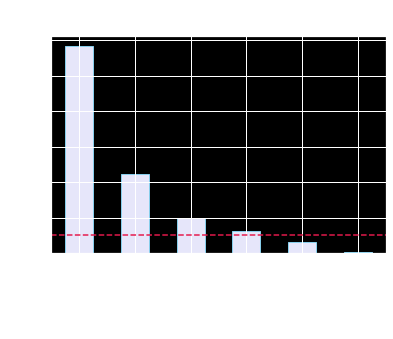

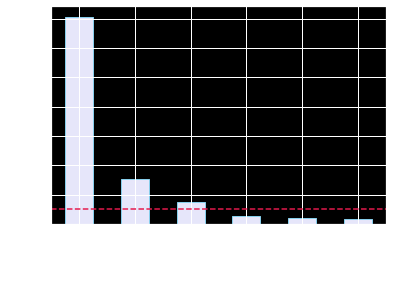

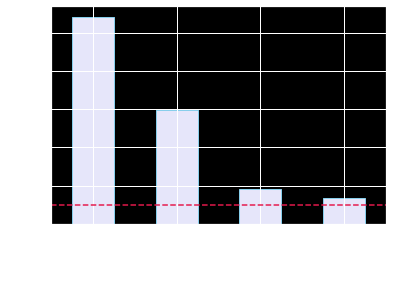

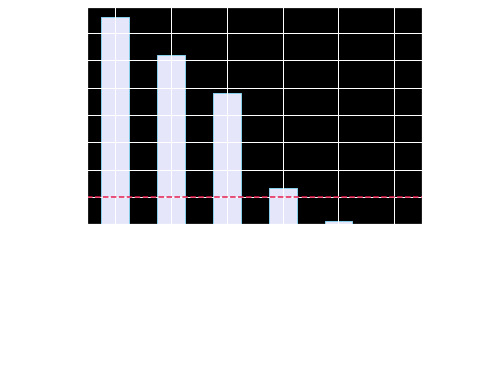

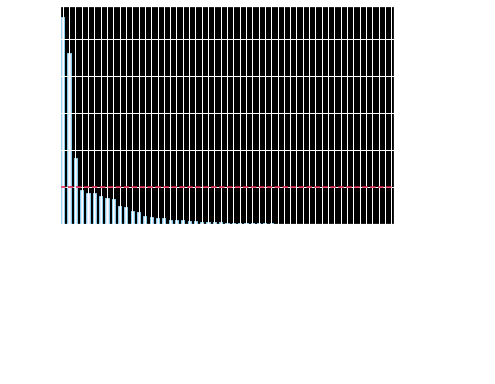

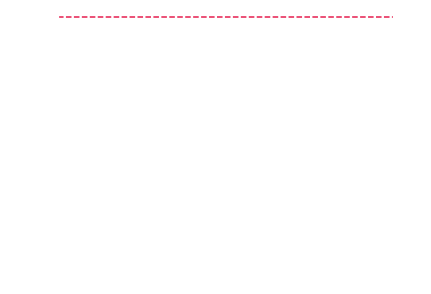

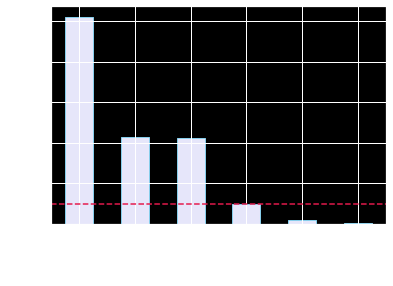

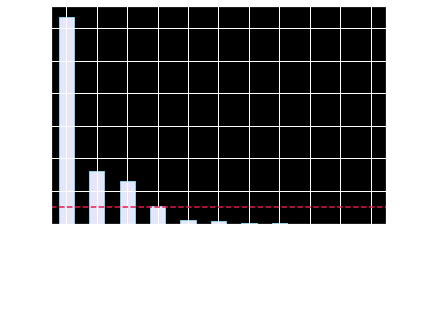

In [20]:
categoricals_plot(df,categorical)

In [21]:
df.drop('fecha de perfeccionamiento', axis=1, inplace=True)

In [23]:
df.columns

Index(['producto', 'valor vencido', 'regional', 'franja', 'segmento',
       'cuadrante', 'descripcion causal', 'calificacion real',
       'rango endeudamiento', 'ocupacion'],
      dtype='object')

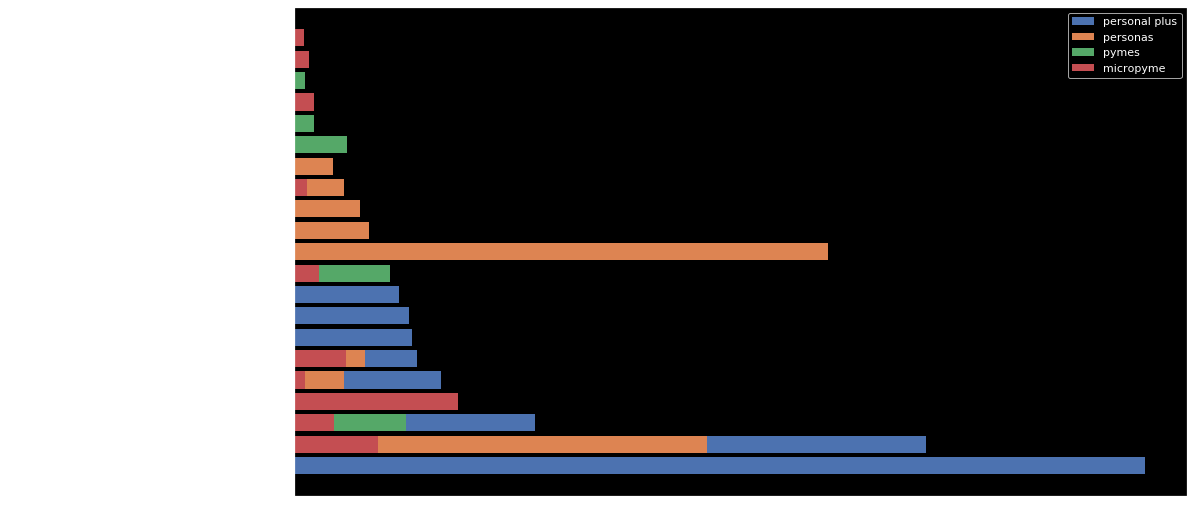

In [24]:
fig, ax = plt.subplots(figsize =(16, 9))

df.dropna(subset=['segmento'], inplace=True)

for segment in df['segmento'].unique():
  list_causes = df[ df['segmento']==segment ]['descripcion causal'].unique()[:10]
  count_causes = df[ df['segmento']==segment ]['descripcion causal'].value_counts()[:10]
  count_causes = count_causes.to_dict()

  ax.barh(list_causes, count_causes.values(), label=segment)
ax.legend()


ValueError: shape mismatch: objects cannot be broadcast to a single shape

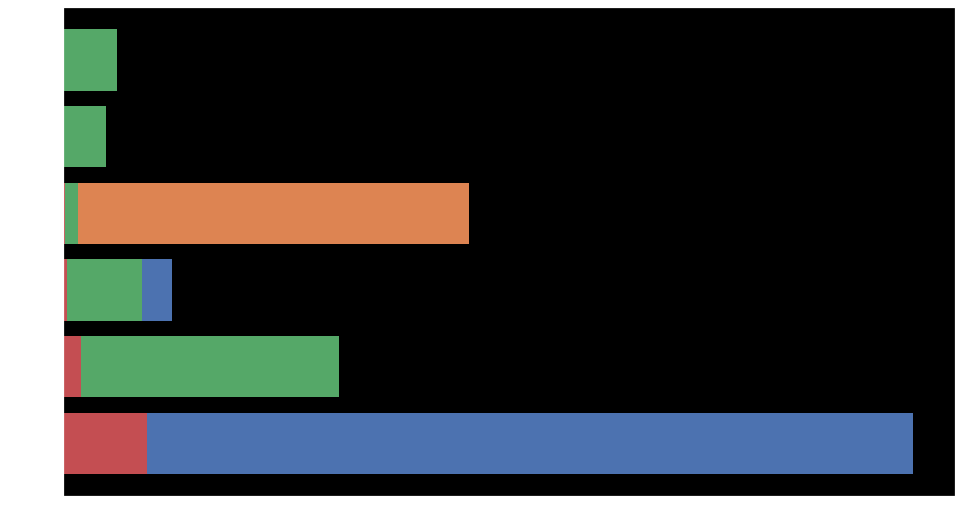

In [27]:
fig, ax = plt.subplots(figsize =(16, 9))
df.dropna(subset=['rango endeudamiento'], inplace=True)
for segment in df['rango endeudamiento'].unique():
    list_causes = df[ df['rango endeudamiento']==segment ]['franja'].unique()[:10]
    count_causes = df[ df['rango endeudamiento']==segment ]['franja'].value_counts()[:10]
    count_causes = count_causes.to_dict()
    ax.barh(list_causes, count_causes.values(), label=segment)
ax.legend()